In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys, time, glob
import pyccl as ccl
import see_fits
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/')
import abundance as cl_count
import covariance as covar
import mvp_pdf
import edit
import forecast
import utils
import importance_sampling as imp_samp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
a

NameError: name 'a' is not defined

real_cluster_abudance

In [4]:
x = np.linspace(1,10,10)
def model(theta):
    a, b = theta
    return a * x + b

In [5]:
true_value = [1,1]

In [6]:
cov_full = np.zeros([len(x), len(x)])
cov_diag = np.zeros([len(x), len(x)])

In [7]:
A = 1
for i in range(len(x)):
    for j in range(len(x)):
        cov_full[i,j] = A * np.exp(-abs(x[i]-x[j])**1)

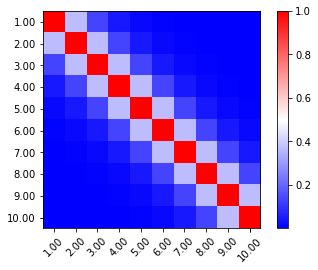

In [8]:
plt.imshow(cov_full, cmap = 'bwr')
x_ticks = [f'{z:.2f}' for z in x]
index = np.arange(len(x))
index_split = np.split(index, 10)
ticks = [index_split[i][0] for i in range(10)]
ticks.append(len(x) - 1)
plt.xticks(ticks=ticks, labels=x_ticks, rotation = 45)
plt.yticks(ticks=ticks, labels=x_ticks)
plt.colorbar()

In [9]:
model(true_value).shape

(10,)

In [10]:
d_model=forecast.first_derivative(true_value, model, model(true_value).shape, delta = 1e-5)

In [11]:
def F(SigmaX, SigmaY, d_model):
    SigmaY_1 = np.linalg.inv(SigmaY)
    res=np.zeros([2,2])
    for i in range(2):
        for j in range(2):
            res[i,j] = np.sum(d_model[i,:] * np.dot(SigmaY_1, np.dot(SigmaX, SigmaY_1) ).dot(d_model[j,:]))
    return res

In [12]:
FXX = F(cov_full, cov_full, d_model)
FXY = F(cov_full, np.diag(cov_full.diagonal()), d_model)
FYX = F(np.diag(cov_full.diagonal()), cov_full, d_model)
FYY = F(np.diag(cov_full.diagonal()), np.diag(cov_full.diagonal()), d_model)

TypeError: _make_ellipse() got an unexpected keyword argument 'n_sigma'

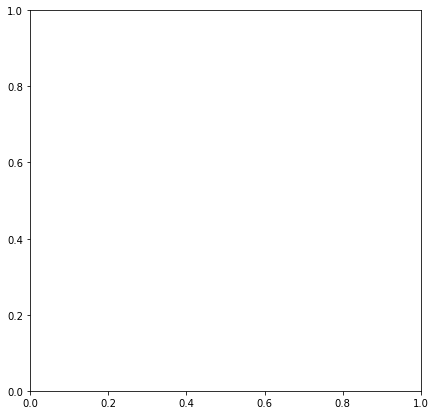

In [13]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
utils._make_ellipse(true_value, np.linalg.inv(FXX), ax, level=0.95,n_sigma=1, color='k', label = r'$F_{XX}$', ls = '-')
utils._make_ellipse(true_value, np.linalg.inv(FXY), ax, level=0.95,n_sigma=1, color='r', label = r'$F_{XY}$', ls = '--')
utils._make_ellipse(true_value, np.linalg.inv(FYX), ax, level=0.95,n_sigma=1, color='g', label = r'$F_{YX}$', ls = '--')
utils._make_ellipse(true_value, np.linalg.inv(FYY), ax, level=0.95,n_sigma=1, color='b', label = r'$F_{YY}$', ls = '-')
ax.set_xlim(true_value[0]-.2, true_value[0]+.2)
ax.set_ylim(true_value[0]-1.5, true_value[1]+1.5)
ax.set_xlabel('a', fontsize=20)
ax.set_ylabel('b', fontsize=20)
ax.tick_params(axis='both', which = 'major', labelsize= 20)
ax.legend(fontsize=20, frameon=False)